In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

In [3]:
import cv2
import imageio

In [4]:
import matplotlib.pyplot as plt

# Topological features of vessel segmentation maps

We import our prepared dataset class, and load the DRIVE training dataset using OpenCV and `imageio`.

In [5]:
from utils.loaders import DATASET_MAP

In [6]:
dataset = DATASET_MAP['DRIVE']['train']

In [230]:
import skimage

_idx = 1
img = cv2.cvtColor(cv2.imread(dataset.images[_idx]), cv2.COLOR_BGR2RGB)
target = np.asarray(imageio.imread(dataset.targets[_idx]))  # this is a gif, load with imageio


target = target.astype(float) / 255

# preprocess the target with gaussian blur for smoothing
target_smoothed = skimage.filters.gaussian(target, 1)

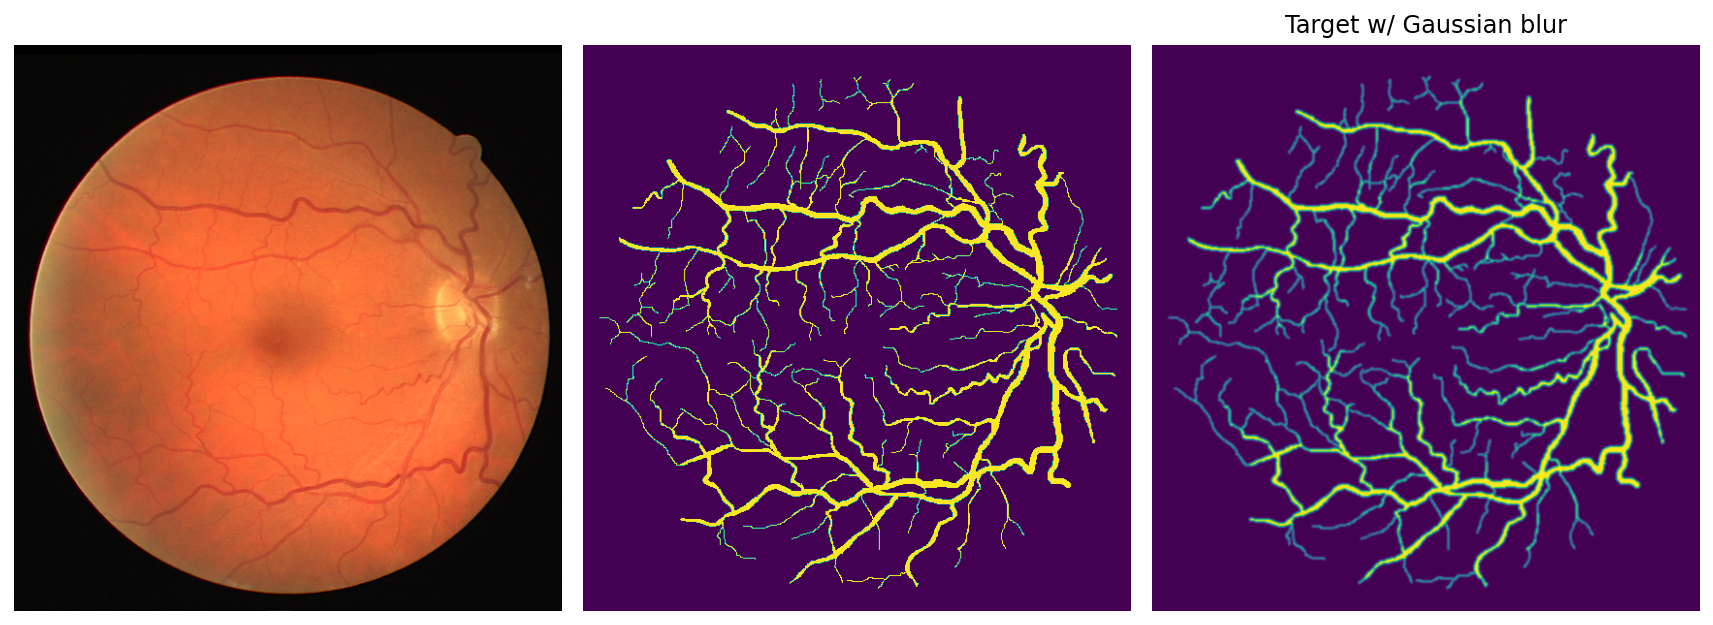

In [231]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.imshow(img)
ax1.axis('off')

ax2.imshow(target)
ax2.axis('off');

ax3.imshow(target_smoothed)
ax3.axis('off');
ax3.set_title("Target w/ Gaussian blur")
fig.tight_layout()

## Persistent homology

Now, we want to extract topological features from the target map using persistent homology. We will use the `gudhi` library for its performance.

Following the approach of [this paper](https://arxiv.org/pdf/1901.10244.pdf) and [repo](https://github.com/JamesClough/topograd), we use a cubical complex built over the pixels and the appropriate Bernoulli-like filtration.

In [232]:
import gudhi as gd
from gudhi import CubicalComplex

### Persistence of the real segmentation map

In [237]:
cub_splx = CubicalComplex(list(target.shape),
                          top_dimensional_cells=1-target.flatten())
print("Cubical complex has %d simplices." % cub_splx.num_simplices())

Cubical complex has 1322139 simplices.


In [238]:
persistence_ = cub_splx.persistence(min_persistence=0.)

print(len(persistence_))

from collections import defaultdict
persistence_dict = defaultdict(list)
for dim, triplet in persistence_:
    persistence_dict[dim].append(triplet)
for dim in persistence_dict:
    persistence_dict[dim] = np.asarray(persistence_dict[dim])

4724


In [239]:
for dim, arr in persistence_dict.items():
    print("Dimension {:d}: persistence values\n".format(dim), np.unique(arr,axis=0))

Dimension 1: persistence values
 [[0. 1.]]
Dimension 0: persistence values
 [[ 0.  1.]
 [ 0. inf]]


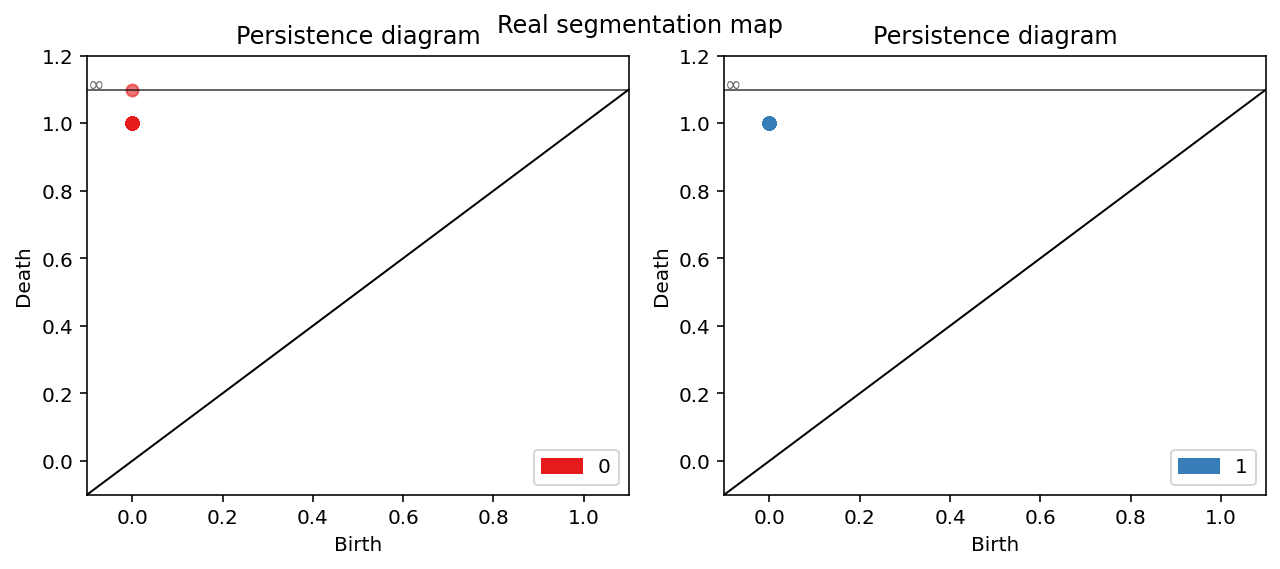

In [240]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(121)
gd.plot_persistence_diagram([t for t in persistence_ if t[0]==0], alpha=.6,
                            legend=True, axes=ax)
ax = fig.add_subplot(122)
gd.plot_persistence_diagram([t for t in persistence_ if t[0]==1], alpha=.6,
                            legend=True, axes=ax)
fig.suptitle("Real segmentation map")
fig.tight_layout()

### Persistence of the blurry segmentation map

Now, we build a cubical complex over the Gaussian-filtered segmentation map:

In [241]:
cub_splx = CubicalComplex(list(target.shape),
                          top_dimensional_cells=1-target_smoothed.flatten())

print("Cubical complex has %d simplices." % cub_splx.num_simplices())

Cubical complex has 1322139 simplices.


In [242]:
persistence_ = cub_splx.persistence(min_persistence=0.)

print(len(persistence_))

from collections import defaultdict
persistence_dict = defaultdict(list)
for dim, triplet in persistence_:
    persistence_dict[dim].append(triplet)
for dim in persistence_dict:
    persistence_dict[dim] = np.asarray(persistence_dict[dim])

7630


In [243]:
for dim, arr in persistence_dict.items():
    print("Dimension {:d}: persistence values\n".format(dim), np.unique(arr,axis=0))

Dimension 1: persistence values
 [[0.05537504 0.05855682]
 [0.05855684 0.69759689]
 [0.05855743 0.29939111]
 ...
 [0.99999941 1.        ]
 [0.99999996 1.        ]
 [0.99999998 1.        ]]
Dimension 0: persistence values
 [[0.         0.04233155]
 [0.         0.1312084 ]
 [0.         0.21448574]
 ...
 [0.99997195 0.99999998]
 [0.99999216 1.        ]
 [0.99999939 0.99999998]]


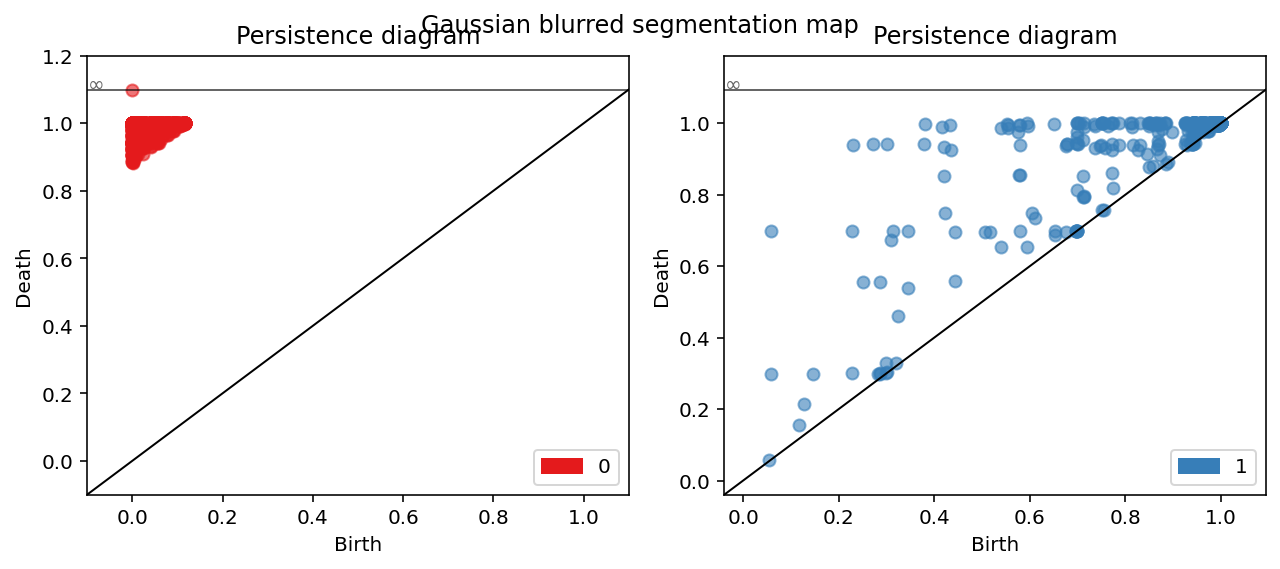

In [244]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(121)
gd.plot_persistence_diagram([t for t in persistence_ if t[0]==0], alpha=.6,
                            legend=True, axes=ax)
ax = fig.add_subplot(122)
gd.plot_persistence_diagram([t for t in persistence_ if t[0]==1], alpha=.6,
                            legend=True, axes=ax)
fig.suptitle("Gaussian blurred segmentation map")
fig.tight_layout()